In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Jun 25 00:25:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:19:00.0 Off |                  Off |
|  0%   43C    P8             26W /  450W |      11MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os

import numpy as np
import torch as th

from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

In [3]:
from easydict import EasyDict
defaults = EasyDict(
    clip_denoised=True,
    num_samples=10000,
    batch_size=16,
    use_ddim=False,
    model_path="",
)
defaults.update(model_and_diffusion_defaults())

args = defaults
args.attention_resolutions = "32,16,8"
args.class_cond = False
args.diffusion_steps = 1000
args.dropout = 0.1 
args.image_size = 64 
args.learn_sigma = False
args.noise_schedule = 'cosine'
args.num_channels = 192 
args.num_head_channels = 64 
args.num_res_blocks = 3 
args.resblock_updown = True
args.use_new_attention_order = True
args.use_fp16 = True
args.use_scale_shift_norm = True


In [4]:
!ls -lt /data/openai_log/64x64_fm_warm6

total 27672784
-rw-rw-r-- 1 scpark scpark    1970122  4월 26 16:41 log.txt
-rw-rw-r-- 1 scpark scpark     936128  4월 26 16:41 progress.csv
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 14:40 opt780000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 14:40 ema_0.9999_780000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 14:40 model780000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 12:41 opt770000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 12:41 ema_0.9999_770000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 12:41 model770000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 10:28 opt760000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 10:28 ema_0.9999_760000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 10:28 model760000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 08:07 opt750000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 08:07 ema_0.9999_750000.pt
-rw-rw-r-- 1 scpark scpark 1180631655  4월 26 08:07 model750000.pt
-rw-rw-r-- 1 scpark scpark 2361052375  4월 26 05:46 opt

In [5]:
device = 'cuda:0'
model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
model = model.to(device)

model_path = '/data/openai_log/64x64_fm_warm6/ema_0.9999_780000.pt'
checkpoint = th.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint)
model.convert_to_fp16()
model.eval()
print('done')

done


### Euler

In [6]:
from tqdm import tqdm

T = 100
dt = 1/T
x = torch.randn(10, 3, args.image_size, args.image_size).to(device)

with torch.no_grad():
    for i in tqdm(range(T)):
        t_tensor = torch.ones((len(x),)).to(device) * i/T
        pred = model(x, t_tensor)
        x = x.detach() + pred * dt

x = ((x + 1) * 127.5).clamp(0, 255).to(th.uint8)
x = x.permute(0, 2, 3, 1)
x = x.contiguous()
x = x.data.cpu().numpy()
print(x.shape)

 32%|█████████████▍                            | 32/100 [00:05<00:11,  5.90it/s]

KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 5])
for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Get curvature

In [7]:
from tqdm import tqdm

T = 100
dt = 1/T
x = torch.randn(100, 3, args.image_size, args.image_size).to(device)

v_prev = None
curvatures = []
with torch.no_grad():
    for i in tqdm(range(T)):
        t_tensor = torch.ones((len(x),)).to(device) * i/T
        v = model(x, t_tensor)
        x = x.detach() + v * dt
        if v_prev is None:
            v_prev = v
        x_prev = x.detach() + v_prev * dt
        v_prev = v
        s = F.l1_loss(x, x_prev)
        curvatures.append(s)
        
curvatures = torch.stack(curvatures, dim=0).data.cpu().numpy()
print(curvatures.shape)

100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


(100,)


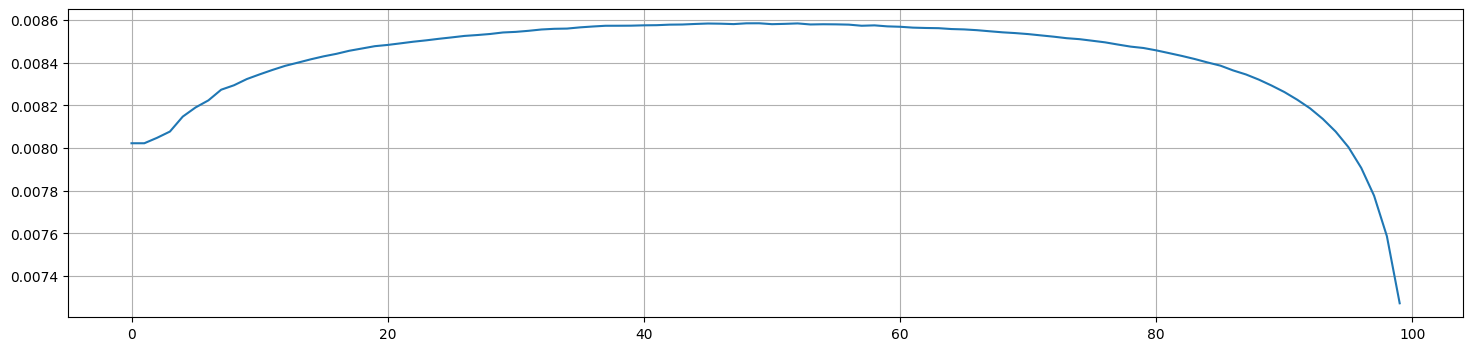

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 4])
plt.plot(curvatures)
plt.grid()
plt.show()

### torchdiffeq

In [8]:
from torchdiffeq import odeint

def func(t, y):
    print(t)
    t = torch.Tensor([t]).to(device)
    with torch.no_grad():
        pred = model(y, t)
    return pred.detach()

x = torch.randn(10, 3, args.image_size, args.image_size).to(device)
t = torch.linspace(0., 1., steps=10).to(device)
x = odeint(func, x, t, method='dopri5', atol=1e-5, rtol=1e-5)[-1]

x = ((x + 1) * 127.5).clamp(0, 255).to(th.uint8)
x = x.permute(0, 2, 3, 1)
x = x.contiguous()
x = x.data.cpu().numpy()
print(x.shape)

tensor(0., device='cuda:0')
tensor(0.0099, device='cuda:0')
tensor(0.0058, device='cuda:0')
tensor(0.0086, device='cuda:0')
tensor(0.0230, device='cuda:0')
tensor(0.0256, device='cuda:0')
tensor(0.0288, device='cuda:0')
tensor(0.0288, device='cuda:0')
tensor(0.0362, device='cuda:0')
tensor(0.0399, device='cuda:0')
tensor(0.0586, device='cuda:0')
tensor(0.0619, device='cuda:0')
tensor(0.0660, device='cuda:0')
tensor(0.0660, device='cuda:0')
tensor(0.0738, device='cuda:0')
tensor(0.0776, device='cuda:0')
tensor(0.0970, device='cuda:0')
tensor(0.1005, device='cuda:0')
tensor(0.1048, device='cuda:0')
tensor(0.1048, device='cuda:0')
tensor(0.1159, device='cuda:0')
tensor(0.1215, device='cuda:0')
tensor(0.1493, device='cuda:0')
tensor(0.1542, device='cuda:0')
tensor(0.1604, device='cuda:0')
tensor(0.1604, device='cuda:0')
tensor(0.1732, device='cuda:0')
tensor(0.1795, device='cuda:0')
tensor(0.2114, device='cuda:0')
tensor(0.2170, device='cuda:0')
tensor(0.2241, device='cuda:0')
tensor(0.224

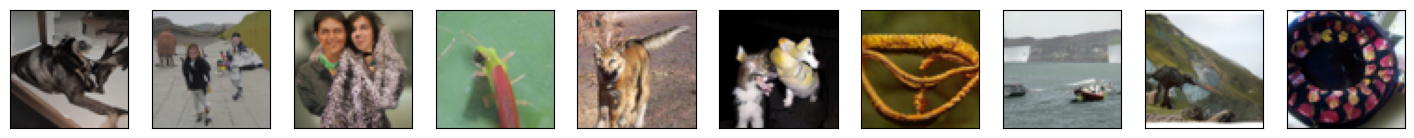

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 5])
for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Save .npz

In [8]:
from tqdm import tqdm

def sample_images(n_samples=100, T=100):
    dt = 1./T
    z = torch.randn(n_samples, 3, 64, 64).to(device)
    with torch.no_grad():
        for i in tqdm(range(T)):
            t = torch.ones((len(z),)).to(device) * i/T
            pred = model(z, t)
            z = z.detach() + pred * dt

    sample = ((z + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.data.cpu().numpy()
    return sample
    

In [10]:
!ls /home/scpark/guided-diffusion/evaluations

'18k_T=100_euler.npz'		  classify_image_graph_def.pb
 FID.ipynb			  evaluator.py
 README.md			  iddpm_imagenet64.npz
 VIRTUAL_imagenet64_labeled.npz  'infer03.23-1_T=100_euler.npz'
 __pycache__			 'infer04.12-1_T=100_euler.npz'
 celeba_ref.npz			  requirements.txt
 celeba_ref2.npz


In [11]:
samples_list = [] 
for i in range(100):
    samples = sample_images(100, 100)
    samples_list.append(samples)
    
samples = np.concatenate(samples_list, axis=0)
print(samples.shape)

npz_file = '/home/scpark/guided-diffusion/evaluations/86k_T=100_euler.npz'
np.savez(npz_file, samples, allow_pickle=True)
print('done')

100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


(10000, 64, 64, 3)
done


### Save .npz Dopri5

In [9]:
from tqdm import tqdm

def sample_images_dopri5(n_samples=100):
    from torchdiffeq import odeint

    def func(t, y):
        t = torch.Tensor([t]).to(device)
        with torch.no_grad():
            pred = model(y, t)
        return pred.detach()

    x = torch.randn(n_samples, 3, args.image_size, args.image_size).to(device)
    t = torch.linspace(0., 1., steps=10).to(device)
    x = odeint(func, x, t, method='dopri5', atol=1e-5, rtol=1e-5)[-1]

    sample = ((x + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.data.cpu().numpy()
    return sample
    

In [ ]:
from tqdm import tqdm
samples_list = [] 
for i in tqdm(range(100)):
    print(i)
    samples = sample_images_dopri5(100)
    samples_list.append(samples)
    
samples = np.concatenate(samples_list, axis=0)
print(samples.shape)

npz_file = '/home/scpark/guided-diffusion/evaluations/19.28epoch_dopri5.npz'
np.savez(npz_file, samples, allow_pickle=True)
print('done')

  0%|                                                   | 0/100 [00:00<?, ?it/s]

0


  1%|▍                                        | 1/100 [01:02<1:43:02, 62.45s/it]

1


  2%|▊                                        | 2/100 [02:07<1:44:25, 63.93s/it]

2


  3%|█▏                                       | 3/100 [03:09<1:42:12, 63.22s/it]

3


  4%|█▋                                       | 4/100 [04:15<1:42:26, 64.03s/it]

4


  5%|██                                       | 5/100 [05:20<1:42:05, 64.48s/it]

5


  6%|██▍                                      | 6/100 [06:25<1:41:27, 64.77s/it]

6


  7%|██▊                                      | 7/100 [07:31<1:40:40, 64.96s/it]

7


  8%|███▎                                     | 8/100 [08:36<1:39:48, 65.09s/it]

8


  9%|███▋                                     | 9/100 [09:44<1:40:12, 66.07s/it]

9


 10%|████                                    | 10/100 [10:47<1:37:31, 65.02s/it]

10


 11%|████▍                                   | 11/100 [11:55<1:37:54, 66.01s/it]

11


 12%|████▊                                   | 12/100 [13:03<1:37:48, 66.69s/it]

12


 13%|█████▏                                  | 13/100 [14:06<1:34:54, 65.45s/it]

13


 14%|█████▌                                  | 14/100 [15:11<1:33:47, 65.44s/it]

14


 15%|██████                                  | 15/100 [16:14<1:31:28, 64.57s/it]

15


 16%|██████▍                                 | 16/100 [17:19<1:30:44, 64.82s/it]

16


 17%|██████▊                                 | 17/100 [18:22<1:28:45, 64.16s/it]

17


 18%|███████▏                                | 18/100 [19:27<1:28:12, 64.54s/it]

18


 19%|███████▌                                | 19/100 [20:33<1:27:29, 64.81s/it]

19


 20%|████████                                | 20/100 [21:44<1:28:54, 66.68s/it]

20


 21%|████████▍                               | 21/100 [22:52<1:28:24, 67.15s/it]

21


 22%|████████▊                               | 22/100 [24:00<1:27:42, 67.47s/it]

22


 23%|█████████▏                              | 23/100 [25:03<1:24:42, 66.01s/it]

23


 24%|█████████▌                              | 24/100 [26:08<1:23:23, 65.83s/it]

24


 25%|██████████                              | 25/100 [27:11<1:21:04, 64.86s/it]

25


 26%|██████████▍                             | 26/100 [28:16<1:20:11, 65.02s/it]

26


 27%|██████████▊                             | 27/100 [29:22<1:19:15, 65.14s/it]

27


 28%|███████████▏                            | 28/100 [30:27<1:18:16, 65.23s/it]

28


 29%|███████████▌                            | 29/100 [31:33<1:17:15, 65.29s/it]

29


 30%|████████████                            | 30/100 [32:44<1:18:11, 67.02s/it]

30


 31%|████████████▍                           | 31/100 [33:55<1:18:26, 68.22s/it]

31


 32%|████████████▊                           | 32/100 [35:00<1:16:21, 67.38s/it]

32


 33%|█████████████▏                          | 33/100 [36:05<1:14:35, 66.80s/it]

33


 34%|█████████████▌                          | 34/100 [37:11<1:13:01, 66.39s/it]

34


 35%|██████████████                          | 35/100 [38:16<1:11:36, 66.09s/it]

35


 36%|██████████████▍                         | 36/100 [39:22<1:10:16, 65.88s/it]

36


 37%|██████████████▊                         | 37/100 [40:27<1:09:01, 65.73s/it]

37


 38%|███████████████▏                        | 38/100 [41:33<1:07:49, 65.64s/it]

38


 39%|███████████████▌                        | 39/100 [42:38<1:06:40, 65.58s/it]

39


 40%|████████████████                        | 40/100 [43:43<1:05:32, 65.54s/it]

40


 41%|████████████████▍                       | 41/100 [44:46<1:03:35, 64.67s/it]

41


 42%|████████████████▊                       | 42/100 [45:54<1:03:32, 65.74s/it]

42


 43%|█████████████████▏                      | 43/100 [46:57<1:01:33, 64.80s/it]

43


 44%|█████████████████▌                      | 44/100 [48:02<1:00:39, 64.99s/it]

44


 45%|██████████████████▉                       | 45/100 [49:08<59:41, 65.12s/it]

45


 46%|███████████████████▎                      | 46/100 [50:10<57:55, 64.36s/it]

46


 47%|███████████████████▋                      | 47/100 [51:16<57:07, 64.67s/it]

47


 48%|████████████████████▏                     | 48/100 [52:16<54:46, 63.21s/it]

48


 49%|████████████████████▌                     | 49/100 [53:21<54:17, 63.87s/it]

49


 50%|█████████████████████                     | 50/100 [54:24<52:54, 63.50s/it]

50


 51%|█████████████████████▍                    | 51/100 [55:26<51:38, 63.24s/it]

51


 52%|█████████████████████▊                    | 52/100 [56:29<50:27, 63.06s/it]

52


 53%|██████████████████████▎                   | 53/100 [57:34<49:57, 63.78s/it]

53


 54%|██████████████████████▋                   | 54/100 [58:40<49:16, 64.28s/it]

54


 55%|███████████████████████                   | 55/100 [59:45<48:27, 64.62s/it]

55


 56%|██████████████████████▍                 | 56/100 [1:00:56<48:47, 66.54s/it]

56


 57%|██████████████████████▊                 | 57/100 [1:02:02<47:26, 66.20s/it]

57


 58%|███████████████████████▏                | 58/100 [1:03:07<46:10, 65.96s/it]

58


 59%|███████████████████████▌                | 59/100 [1:04:12<44:57, 65.78s/it]

59


 60%|████████████████████████                | 60/100 [1:05:15<43:12, 64.82s/it]

60


 61%|████████████████████████▍               | 61/100 [1:06:20<42:14, 65.00s/it]

61


 62%|████████████████████████▊               | 62/100 [1:07:26<41:14, 65.13s/it]

62


 63%|█████████████████████████▏              | 63/100 [1:08:31<40:13, 65.22s/it]

63


 64%|█████████████████████████▌              | 64/100 [1:09:39<39:40, 66.12s/it]

64


 65%|██████████████████████████              | 65/100 [1:10:45<38:26, 65.91s/it]

65


 66%|██████████████████████████▍             | 66/100 [1:11:50<37:16, 65.78s/it]

66


 67%|██████████████████████████▊             | 67/100 [1:12:56<36:07, 65.67s/it]

67


 68%|███████████████████████████▏            | 68/100 [1:14:01<34:58, 65.59s/it]

68


 69%|███████████████████████████▌            | 69/100 [1:15:07<33:51, 65.54s/it]

69


 70%|████████████████████████████            | 70/100 [1:16:20<34:00, 68.02s/it]

70


 71%|████████████████████████████▍           | 71/100 [1:17:26<32:29, 67.24s/it]

71


 72%|████████████████████████████▊           | 72/100 [1:18:28<30:43, 65.85s/it]

72


 73%|█████████████████████████████▏          | 73/100 [1:19:39<30:20, 67.41s/it]

73


 74%|█████████████████████████████▌          | 74/100 [1:20:45<28:57, 66.82s/it]

74


 75%|██████████████████████████████          | 75/100 [1:21:53<28:01, 67.25s/it]

75


 76%|██████████████████████████████▍         | 76/100 [1:22:59<26:40, 66.71s/it]

76


 77%|██████████████████████████████▊         | 77/100 [1:24:07<25:44, 67.17s/it]

77


 78%|███████████████████████████████▏        | 78/100 [1:25:12<24:26, 66.65s/it]

78


 79%|███████████████████████████████▌        | 79/100 [1:26:12<22:36, 64.60s/it]

79


 80%|████████████████████████████████        | 80/100 [1:27:18<21:37, 64.85s/it]

80


In [12]:
print('done')

done
